In [23]:
import pandas
import itertools

import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt

from copy import deepcopy
from nilearn import image, plotting
from mpl_toolkits.mplot3d import Axes3D
from scipy import ndimage


%matplotlib inline

In [2]:
mni = nib.load('../data/MNI152_T1_1mm_brain.nii.gz')

## DKT

In [3]:
dkt = nib.load('../data/DKT_w_hipp_labels_gk.nii.gz')

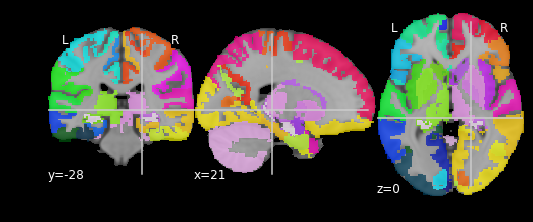

In [4]:
plotting.plot_roi(dkt, mni)

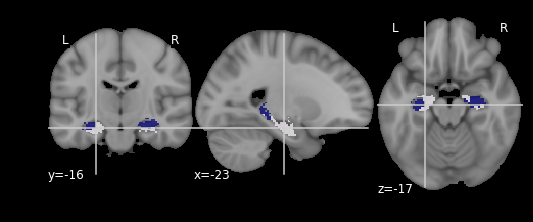

In [5]:
dkt_hippo_data = deepcopy(dkt.get_data())
dkt_hippo_data[dkt_hippo_data < 84] = 0  # Hippocampal labels are 84 and 85, remove all others
dkt_hippo = nib.Nifti1Image(dkt_hippo_data, dkt.affine, dkt.header)
plotting.plot_roi(dkt_hippo, mni)

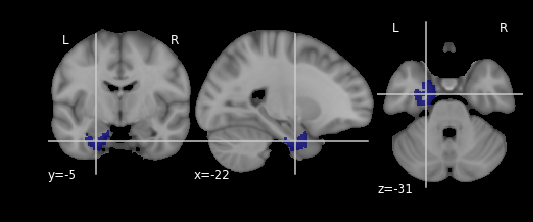

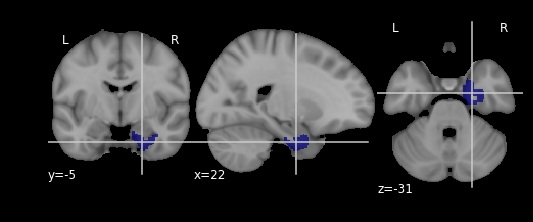

In [6]:
dkt_erc_left_data = deepcopy(dkt.get_data())
dkt_erc_left_data[dkt_erc_left_data != 4] = 0  # ERC left label is 4, right is 43, remove all others
dkt_erc_left = nib.Nifti1Image(dkt_erc_left_data, dkt.affine, dkt.header)
plotting.plot_roi(dkt_erc_left, mni)

dkt_erc_right_data = deepcopy(dkt.get_data())
dkt_erc_right_data[dkt_erc_right_data != 43] = 0  # ERC left label is 4, right is 43, remove all others
dkt_erc_right = nib.Nifti1Image(dkt_erc_right_data, dkt.affine, dkt.header)
plotting.plot_roi(dkt_erc_right, mni)

nib.save(dkt_erc_left, '../data/DKT_w_erc_labels_left_gk.nii.gz')
nib.save(dkt_erc_right, '../data/DKT_w_erc_labels_right_gk.nii.gz')

### Split into LR

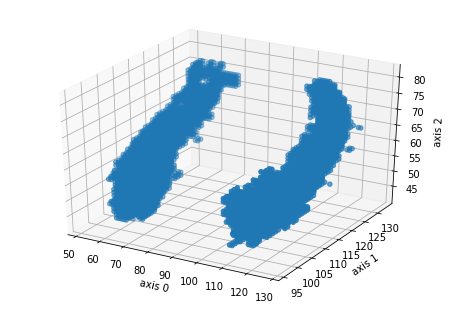

In [7]:
label_locations = np.where(dkt_hippo_data > 0)
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(label_locations[0], label_locations[1], label_locations[2])
# To split into LR, we need to visualize where the LR split is, where front is

ax.set_xlabel('axis 0')
ax.set_ylabel('axis 1')
ax.set_zlabel('axis 2')
plt.show()

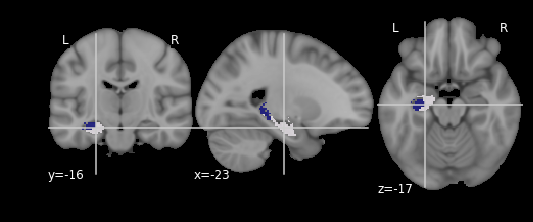

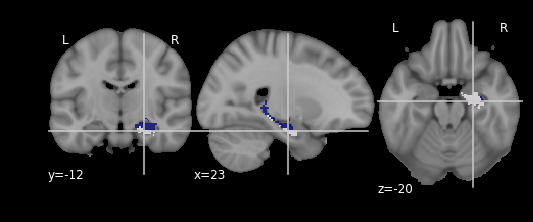

In [8]:
# From the above, we can split the LR data at x=90, and front is lower in y=0
# Thus, Left: x > 90, Right: x <= 90
boundary = 90
x_locations = set([x for x, y, z in zip(*label_locations)])
left_label_locations  = [(x, y, z) for x, y, z in zip(*label_locations) if x > 90]
right_label_locations = [(x, y, z) for x, y, z in zip(*label_locations) if x <= 90]

dkt_hippo_left_data = deepcopy(dkt_hippo_data)
dkt_hippo_left_data[0:boundary,:,:] = 0
dkt_hippo_left = nib.Nifti1Image(dkt_hippo_left_data, dkt.affine, dkt.header)

dkt_hippo_right_data = deepcopy(dkt_hippo_data)
dkt_hippo_right_data[boundary:,:,:] = 0
dkt_hippo_right = nib.Nifti1Image(dkt_hippo_right_data, dkt.affine, dkt.header)

plotting.plot_roi(dkt_hippo_left, mni)
plotting.plot_roi(dkt_hippo_right, mni)

In [9]:
nib.save(dkt_hippo_left, '../data/DKT_w_hippo_labels_left_gk.nii.gz')
nib.save(dkt_hippo_right, '../data/DKT_w_hippo_labels_right_gk.nii.gz')

#### Load left-right parcellations (if not generated above)

In [10]:
dkt_hippo_left = nib.load('../data/DKT_w_hippo_labels_left_gk.nii.gz')
dkt_hippo_left_data = dkt_hippo_left.get_data()

dkt_hippo_right = nib.load('../data/DKT_w_hippo_labels_right_gk.nii.gz')
dkt_hippo_right_data = dkt_hippo_right.get_data()

dkt_erc_left = nib.load('../data/DKT_w_erc_labels_left_gk.nii.gz')
dkt_erc_left_data = dkt_erc_left.get_data()

dkt_erc_right = nib.load('../data/DKT_w_erc_labels_right_gk.nii.gz')
dkt_erc_right_data = dkt_erc_right.get_data()

### Weight by region size

In [11]:
dkt_hippo_left_sizes = dict(zip(*np.unique(dkt_hippo_left_data, return_counts=True)))
del dkt_hippo_left_sizes[0.0]
print("Left: {}".format(dkt_hippo_left_sizes))


dkt_hippo_right_sizes = dict(zip(*np.unique(dkt_hippo_right_data, return_counts=True)))
del dkt_hippo_right_sizes[0.0]

print("Right: {}".format(dkt_hippo_right_sizes))

np.save('../data/dkt_hippo_left_sizes',
        [dkt_hippo_left_sizes[84], dkt_hippo_left_sizes[85]],
        allow_pickle=False)

np.save('../data/dkt_hippo_right_sizes',
        [dkt_hippo_right_sizes[84], dkt_hippo_right_sizes[85]],
        allow_pickle=False)

Left: {84.0: 2232, 85.0: 2240}
Right: {84.0: 3003, 85.0: 1296}


### Weight by centroid distances

In [12]:
dkt_hippo_left_centroids = {
    84 : np.mean(np.where(dkt_hippo_left_data == 84), axis=1),
    85 : np.mean(np.where(dkt_hippo_left_data == 85), axis=1)
}
print("Left Hippo Centroids: {}".format(dkt_hippo_left_centroids))

dkt_hippo_right_centroids = {
    84: np.mean(np.where(dkt_hippo_right_data == 84), axis=1),
    85: np.mean(np.where(dkt_hippo_right_data == 85), axis=1)
}
print("Right Hippo Centroids: {}".format(dkt_hippo_right_centroids))

dkt_erc_left_centroids = np.mean(np.where(dkt_erc_left_data == 4), axis=1)
print("Left ERC Centroids: {}".format(dkt_erc_left_centroids))


dkt_erc_right_centroids = np.mean(np.where(dkt_erc_right_data == 43), axis=1)
print("Right ERC Centroids: {}".format(dkt_erc_right_centroids))

Left Hippo Centroids: {84: array([ 118.05645161,  118.01971326,   62.80197133]), 85: array([ 113.26383929,  107.98080357,   54.45625   ])}
Right Hippo Centroids: {84: array([  61.995338  ,  114.42690643,   61.74958375]), 85: array([  65.8287037 ,  105.17746914,   51.95447531])}
Left ERC Centroids: [ 112.69011407   96.90304183   40.76763836]
Right ERC Centroids: [ 67.6626449   96.0193991   40.53158268]


In [13]:
dkt_hippo_left_distances = {key: np.linalg.norm(dkt_hippo_left_centroids[key] - dkt_erc_left_centroids)
                            for key in dkt_hippo_left_centroids.keys()}
print("Left Hippo Distances: {}".format(dkt_hippo_left_distances))

dkt_hippo_right_distances = {key: np.linalg.norm(dkt_hippo_right_centroids[key] - dkt_erc_right_centroids)
                             for key in dkt_hippo_right_centroids.keys()}
print("Right Hippo Distances: {}".format(dkt_hippo_right_distances))

np.save('../data/dkt_hippo_left_distances',
        [dkt_hippo_left_distances[84], dkt_hippo_left_distances[85]],
        allow_pickle=False)

np.save('../data/dkt_hippo_right_distances',
        [dkt_hippo_right_distances[84], dkt_hippo_right_distances[85]],
        allow_pickle=False)

Left Hippo Distances: {84: 30.987468764474539, 85: 17.618855086028269}
Right Hippo Distances: {84: 28.655859135557947, 85: 14.755204607959755}


# Redo with new hippocampus labels

### Size

In [2]:
atlas_img = nib.load('../data/dilated_hipp_parcellation_FULL_EC_gspace.nii.gz')
atlas = atlas_img.get_data()

In [4]:
sizes = dict(zip(*np.unique(atlas, return_counts=True)))
del sizes[0.0]
np.save('../data/dkt_hippo_left_sizes',
        [dkt_hippo_left_sizes[84], dkt_hippo_left_sizes[85]],
        allow_pickle=False)

{1: 4649, 2: 4205, 3: 2725, 4: 1720, 5: 1913, 6: 2361}

//anaconda/envs/py3/lib/python3.5/site-packages/matplotlib/cbook.py:136: MatplotlibDeprecationWarning: The axisbg attribute was deprecated in version 2.0. Use facecolor instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


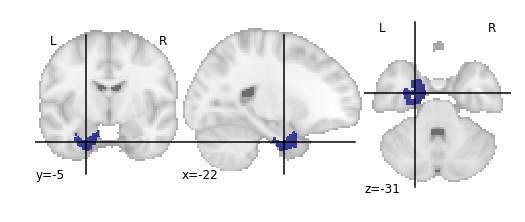

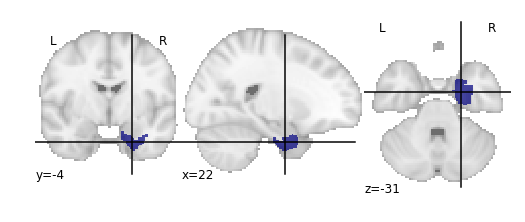

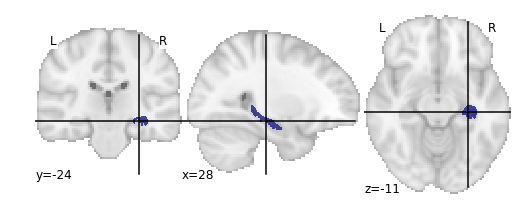

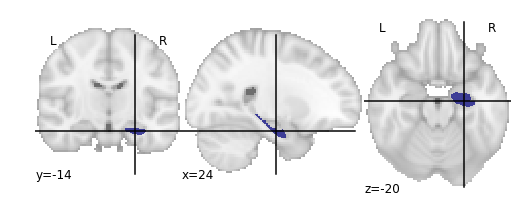

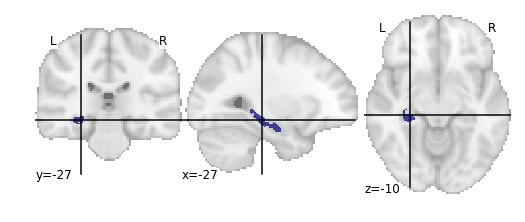

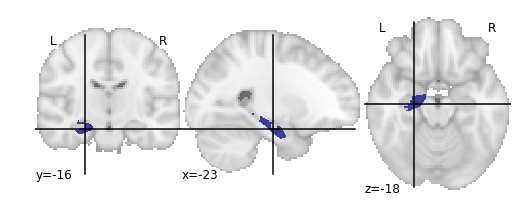

In [15]:
for i in np.unique(atlas)[1:]:
    jnk = np.zeros_like(atlas)
    jnk[atlas==i] = 1
    plotting.plot_roi(nib.Nifti1Image(jnk,atlas_img.affine))

In [20]:
df = pandas.DataFrame.from_dict(sizes, orient='index')
df.columns = ['size']
df.loc[:,'roi'] = ['L_ERC', 'R_ERC', 'R_Noise', 'R_Tau', 'L_noise', 'L_tau']
df

,size,roi
1,4649,L_ERC
2,4205,R_ERC
3,2725,R_Noise
4,1720,R_Tau
5,1913,L_noise
6,2361,L_tau


### Distance

In [27]:
l_erc_centroid = np.mean(np.where(atlas == 1), axis = 1)
r_erc_centroid = np.mean(np.where(atlas == 2), axis = 1)
for i in df.index[2:]:
    centroid = np.mean(np.where(atlas == i), axis = 1)
    df.loc[i, 'dist_to_L_ERC'] = np.linalg.norm(centroid - l_erc_centroid)
    df.loc[i, 'dist_to_R_ERC'] = np.linalg.norm(centroid - r_erc_centroid)
df

,size,roi,dist_to_L_ERC,dist_to_R_ERC
1,4649,L_ERC,NaN,NaN
2,4205,R_ERC,NaN,NaN
3,2725,R_Noise,57.816892,28.600430
4,1720,R_Tau,49.380698,14.566127
5,1913,L_noise,30.714319,58.712851
6,2361,L_tau,16.800704,49.227287


In [29]:
df.to_csv('../data/sizes_distances_dilated.csv', index=False)

In [36]:
df.lcdf[df.roi=='L_ERC']['roi'].index

1    L_ERC
Name: roi, dtype: object